In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [56]:
df = pd.read_csv('data/stock_data.csv')

In [35]:
df

,Date,Close/Last,Volume,Open,High,Low
0,09/13/2024,$230.29,59515110,$228.00,$232.67,$226.32
1,09/12/2024,$229.81,72020040,$224.66,$231.45,$223.83
2,09/11/2024,$228.13,83548630,$224.55,$228.47,$216.8003
3,09/10/2024,$226.17,78891140,$220.07,$226.40,$218.6377
4,09/09/2024,$216.27,67443520,$216.20,$219.87,$213.67
...,...,...,...,...,...,...
2512,09/19/2014,$17.288,102014574,$17.1993,$17.4287,$17.018
2513,09/18/2014,$17.588,55342127,$17.5573,$17.7067,$17.488
2514,09/17/2014,$17.4253,77594871,$17.494,$17.6467,$17.30
2515,09/16/2014,$17.3827,124461748,$17.01,$17.4973,$16.828


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2517 non-null   object
 1   Close/Last  2517 non-null   object
 2   Volume      2517 non-null   int64 
 3   Open        2517 non-null   object
 4   High        2517 non-null   object
 5   Low         2517 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [38]:
cols_to_clean = ['Close/Last', 'Open', 'High', 'Low']
for col in cols_to_clean:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace('$', '').str.replace(',', '').astype(float)

In [39]:
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

In [40]:
df

,Date,Close,Volume,Open,High,Low
0,09/13/2024,230.2900,59515110,228.0000,232.6700,226.3200
1,09/12/2024,229.8100,72020040,224.6600,231.4500,223.8300
2,09/11/2024,228.1300,83548630,224.5500,228.4700,216.8003
3,09/10/2024,226.1700,78891140,220.0700,226.4000,218.6377
4,09/09/2024,216.2700,67443520,216.2000,219.8700,213.6700
...,...,...,...,...,...,...
2512,09/19/2014,17.2880,102014574,17.1993,17.4287,17.0180
2513,09/18/2014,17.5880,55342127,17.5573,17.7067,17.4880
2514,09/17/2014,17.4253,77594871,17.4940,17.6467,17.3000
2515,09/16/2014,17.3827,124461748,17.0100,17.4973,16.8280


In [41]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

Performing EDA...


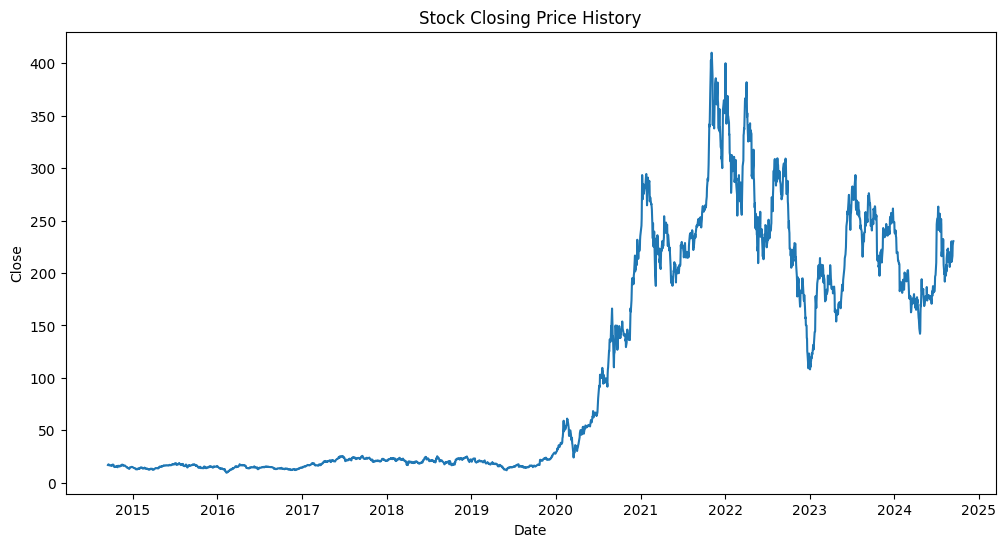

In [42]:
print("Performing EDA...")
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['Date'], y=df['Close'])
plt.title("Stock Closing Price History")
plt.savefig("stock_price_history.png")

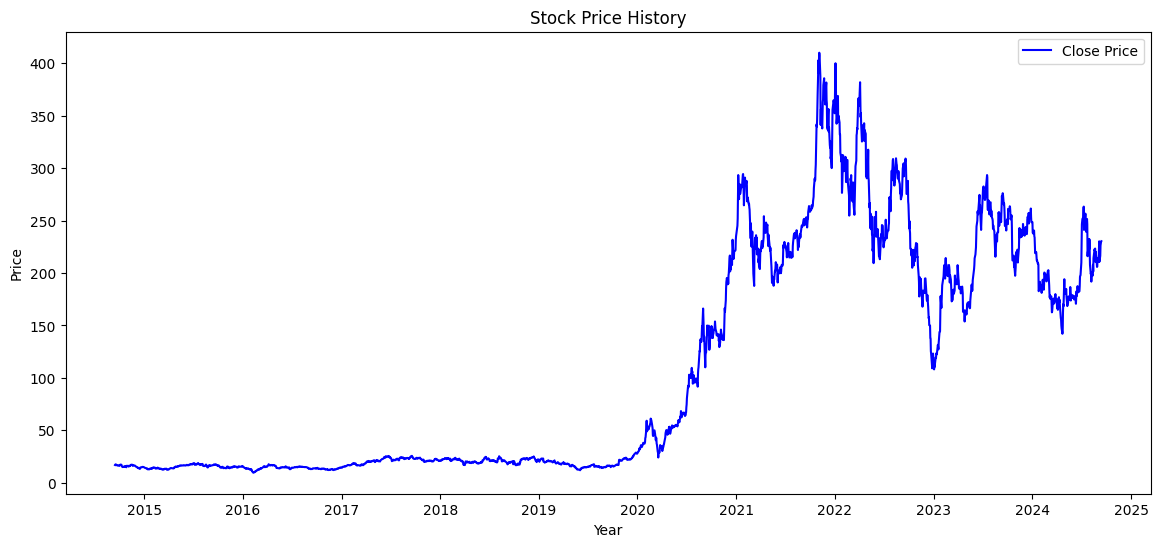

In [43]:

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Stock Price History')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

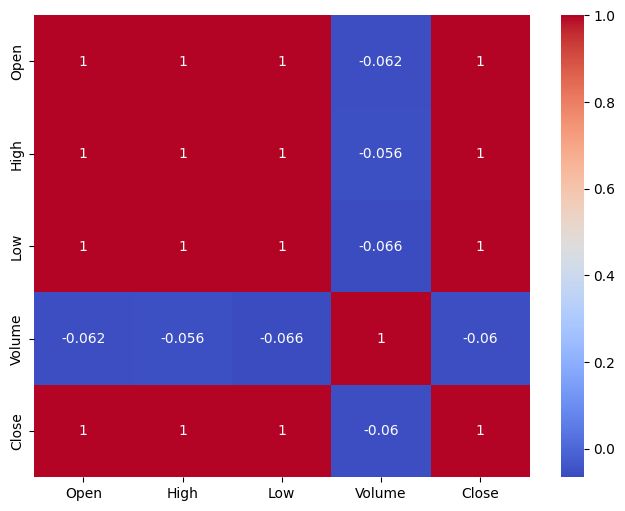

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Volume', 'Close']].corr(), annot=True, cmap='coolwarm')
plt.savefig("stock_correlation.png")

In [45]:
df['MA_50'] = df['Close'].rolling(window=50).mean() 


In [46]:
df['Volatility'] = df['High'] - df['Low']
df = df.dropna()

In [47]:
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

In [48]:
X_train = train_data[['Open', 'High', 'Low', 'Volume', 'MA_50']]
y_train = train_data['Close']
X_test = test_data[['Open', 'High', 'Low', 'Volume', 'MA_50']]
y_test = test_data['Close']

In [49]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

Training Linear Regression...


In [51]:
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, lr_pred)):.2f}")
print(f"Linear Regression R2: {r2_score(y_test, lr_pred):.4f}")

Linear Regression RMSE: 2.54
Linear Regression R2: 0.9956


In [53]:

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [54]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1)) 

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, batch_size=64, epochs=10, verbose=1)

c:\Users\FBC\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 18650.0977
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18230.9590
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16038.0977
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11560.3730
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7907.7451
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5578.5449
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3635.1306
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2210.0916
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1360.6887
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 923.3779


In [55]:
joblib.dump(lr_model, 'models/lr_stock_model.pkl')
joblib.dump(scaler, 'models/stock_scaler.pkl')
lstm_model.save('models/lstm_stock_model.h5')
print(" Stock Analysis Complete & Models Saved.")

 Stock Analysis Complete & Models Saved.
